In [206]:
import os
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
import warnings
import time
import json
import collections
import pydicom as dicom
import matplotlib.patches as patches


from tqdm import tqdm
from matplotlib import animation, rc
from pydicom.pixel_data_handlers.util import apply_voi_lut

In [207]:
# Loading the data

dir_path = '/kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/'  # Directory path

train_df = pd.read_csv(dir_path + 'train.csv')   # Reading train CSV file 
train_label = pd.read_csv(dir_path + 'train_label_coordinates.csv')   # Reading LABEL CSV file for train 
train_desc = pd.read_csv(dir_path + 'train_series_descriptions.csv')  # Reading Train Description CSV file (Meta Data)
test_desc = pd.read_csv(dir_path + 'test_series_descriptions.csv')    # Reading VALIDATION Description CSV file (Meta Data)

submi = pd.read_csv(dir_path + 'sample_submission.csv')     # Reading Sample Submission file for reference

In [208]:
print('Length of the train.csv file = ',len(train_df))
train_df.head(5)

Length of the train.csv file =  1975


,study_id,spinal_canal_stenosis_l1_l2,spinal_canal_stenosis_l2_l3,spinal_canal_stenosis_l3_l4,spinal_canal_stenosis_l4_l5,spinal_canal_stenosis_l5_s1,left_neural_foraminal_narrowing_l1_l2,left_neural_foraminal_narrowing_l2_l3,left_neural_foraminal_narrowing_l3_l4,left_neural_foraminal_narrowing_l4_l5,...,left_subarticular_stenosis_l1_l2,left_subarticular_stenosis_l2_l3,left_subarticular_stenosis_l3_l4,left_subarticular_stenosis_l4_l5,left_subarticular_stenosis_l5_s1,right_subarticular_stenosis_l1_l2,right_subarticular_stenosis_l2_l3,right_subarticular_stenosis_l3_l4,right_subarticular_stenosis_l4_l5,right_subarticular_stenosis_l5_s1
0,4003253,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Moderate,...,Normal/Mild,Normal/Mild,Normal/Mild,Moderate,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild
1,4646740,Normal/Mild,Normal/Mild,Moderate,Severe,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Moderate,...,Normal/Mild,Normal/Mild,Normal/Mild,Severe,Normal/Mild,Normal/Mild,Moderate,Moderate,Moderate,Normal/Mild
2,7143189,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,...,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild
3,8785691,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Moderate,...,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild
4,10728036,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,...,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Moderate,Normal/Mild


In [209]:
'''
# List out all of the Studies we have on patients.
part_1 = os.listdir('/kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images')
part_1 = list(filter(lambda x: x.find('.DS') == -1, part_1))
#part_1
'''

"\n# List out all of the Studies we have on patients.\npart_1 = os.listdir('/kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images')\npart_1 = list(filter(lambda x: x.find('.DS') == -1, part_1))\n#part_1\n"

In [210]:
print('Length of the Training LABELS = ', len(train_label))
train_label.head(5)

Length of the Training LABELS =  48692


,study_id,series_id,instance_number,condition,level,x,y
0,4003253,702807833,8,Spinal Canal Stenosis,L1/L2,322.831858,227.964602
1,4003253,702807833,8,Spinal Canal Stenosis,L2/L3,320.571429,295.714286
2,4003253,702807833,8,Spinal Canal Stenosis,L3/L4,323.030303,371.818182
3,4003253,702807833,8,Spinal Canal Stenosis,L4/L5,335.292035,427.327434
4,4003253,702807833,8,Spinal Canal Stenosis,L5/S1,353.415929,483.964602


In [211]:
# Descripton of the train data
print('Length of train description file = ', len(train_desc))
train_desc

Length of train description file =  6294


,study_id,series_id,series_description
0,4003253,702807833,Sagittal T2/STIR
1,4003253,1054713880,Sagittal T1
2,4003253,2448190387,Axial T2
3,4646740,3201256954,Axial T2
4,4646740,3486248476,Sagittal T1
...,...,...,...
6289,4287160193,1507070277,Sagittal T2/STIR
6290,4287160193,1820446240,Axial T2
6291,4290709089,3274612423,Sagittal T2/STIR
6292,4290709089,3390218084,Axial T2


In [212]:
# Validation csv file 
test_desc 

,study_id,series_id,series_description
0,44036939,2828203845,Sagittal T1
1,44036939,3481971518,Axial T2
2,44036939,3844393089,Sagittal T2/STIR


In [213]:
print('This is the sample submission')
submi

This is the sample submission


,row_id,normal_mild,moderate,severe
0,44036939_left_neural_foraminal_narrowing_l1_l2,0.333333,0.333333,0.333333
1,44036939_left_neural_foraminal_narrowing_l2_l3,0.333333,0.333333,0.333333
2,44036939_left_neural_foraminal_narrowing_l3_l4,0.333333,0.333333,0.333333
3,44036939_left_neural_foraminal_narrowing_l4_l5,0.333333,0.333333,0.333333
4,44036939_left_neural_foraminal_narrowing_l5_s1,0.333333,0.333333,0.333333
5,44036939_left_subarticular_stenosis_l1_l2,0.333333,0.333333,0.333333
6,44036939_left_subarticular_stenosis_l2_l3,0.333333,0.333333,0.333333
7,44036939_left_subarticular_stenosis_l3_l4,0.333333,0.333333,0.333333
8,44036939_left_subarticular_stenosis_l4_l5,0.333333,0.333333,0.333333
9,44036939_left_subarticular_stenosis_l5_s1,0.333333,0.333333,0.333333


In [214]:
def generate_image_paths(df, data_dir):
    image_paths = []
    for _, row in df.iterrows():
        dir_path = os.path.join(data_dir, str(row['study_id']), str(row['series_id']))
        if os.path.exists(dir_path):
            image_paths.extend([os.path.join(dir_path, img) for img in os.listdir(dir_path)])
    return image_paths

In [215]:
# Generate image paths for train and test data
train_img_paths = generate_image_paths(train_desc, f'{dir_path}train_images')
test_img_paths = generate_image_paths(test_desc, f'{dir_path}test_images')

In [216]:
train_img_paths[0:20]

['/kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/4003253/702807833/12.dcm',
 '/kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/4003253/702807833/9.dcm',
 '/kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/4003253/702807833/14.dcm',
 '/kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/4003253/702807833/11.dcm',
 '/kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/4003253/702807833/10.dcm',
 '/kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/4003253/702807833/1.dcm',
 '/kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/4003253/702807833/15.dcm',
 '/kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/4003253/702807833/2.dcm',
 '/kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/4003253/702807833/8.dcm',
 '/kaggle/input/rsna-2024-lumbar-spine-de

In [217]:
print("The number of TRAINING images are = ",len(train_img_paths))
print("The number of TEST images are = ",len(test_img_paths))

The number of TRAINING images are =  147218
The number of TEST images are =  97


In [218]:
import matplotlib.pyplot as plt
print(train_img_paths[113])

/kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/4646740/3201256954/54.dcm


In [219]:
import pydicom
import matplotlib.pyplot as plt

def show_dicom(path):
    try:
        # Read the DICOM file
        img = pydicom.dcmread(path)

        # Get the available tags in the DICOM metadata
        available_tags = img.dir()

        # Display the image
        plt.imshow(img.pixel_array, cmap='gray')

        # Display any available information (e.g., Patient ID, Modality)
        title = "DICOM Info: "
        for tag in ['StudyID', 'PatientID', 'Modality', 'SeriesInstanceUID']:
            if tag in available_tags:
                title += f"{tag}: {getattr(img, tag)} | "

        plt.title(title)
        plt.show()

    except Exception as e:
        print(f"Error loading DICOM file: {e}")


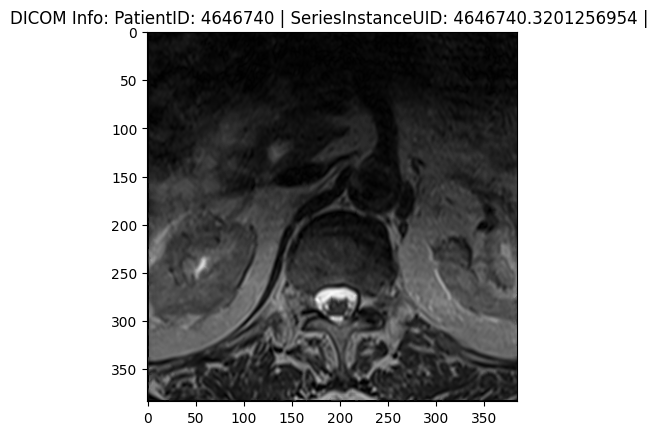

In [220]:
sample_img = show_dicom(train_img_paths[103])

In [221]:
# Calculating the size of the DICOM image
img_1 = dicom.dcmread(train_img_paths[501])
val = np.array(img_1.pixel_array)
val.shape
#val.astype(np.float64)

(384, 384)

In [222]:
# Function to open and display DICOM images
def display_dicom_images(image_paths, start, end):
    num_images = end - start
    cols = 5  # You can adjust this value as needed (5 columns in the plot)
    rows = (num_images + cols - 1) // cols  # This ensures enough rows for all images

    plt.figure(figsize=(15, 5))  # Adjust figure size if needed

    for i, path in enumerate(image_paths[start:end]):
        ds = dicom.dcmread(path)
        plt.subplot(rows, cols, i + 1)  # Creating subplots dynamically
        plt.imshow(ds.pixel_array, cmap=plt.cm.bone)
        plt.title(f"Image {i + 1}")
        plt.axis('off')

    plt.tight_layout()  # This makes sure the subplots are spaced evenly
    plt.show()

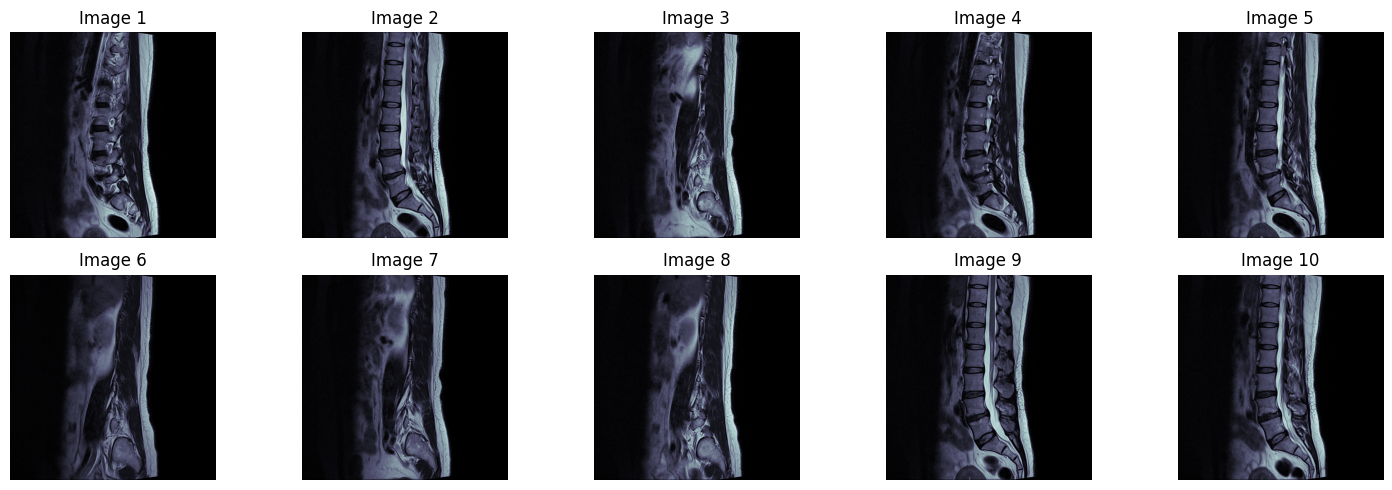

In [223]:
display_dicom_images(train_img_paths,0,10)

In [224]:
# Load DICOM files from a folder
def load_dicom_files(path_to_folder):
    if not os.path.exists(path_to_folder):
        raise FileNotFoundError(f"The folder {path_to_folder} does not exist.")
    
    files = [os.path.join(path_to_folder, f) for f in os.listdir(path_to_folder) if f.endswith('.dcm')]
    
    if not files:
        raise ValueError(f"No DICOM files found in the folder {path_to_folder}.")
    
    files.sort(key=lambda x: int(os.path.splitext(os.path.basename(x))[0].split('-')[-1]))
    
    return files

# Data Preprocessing

In [225]:
#Define function to reshape a single row of the DataFrame
def reshape_row(row):
    data = {'study_id':[], 'condition':[], 'level':[], 'severity':[]}
    for column, value in row.items():
        if column not in ['study_id', 'series_id', 'instance_number', 'x', 'y', 'series_description']:
            parts = column.split('_')
            condition = ' '.join([word.capitalize() for word in parts[:-2]])
            level = parts[-2].capitalize() + '/' + parts[-1].capitalize()
            data['study_id'].append(row['study_id'])
            data['condition'].append(condition)
            data['level'].append(level)
            data['severity'].append(value)
    
    return pd.DataFrame(data)

#Reshape the DataFrame for all rows
new_train_df = pd.concat([reshape_row(row) for _, row in train_df.iterrows()], ignore_index = True)

In [226]:
train_df.head()

,study_id,spinal_canal_stenosis_l1_l2,spinal_canal_stenosis_l2_l3,spinal_canal_stenosis_l3_l4,spinal_canal_stenosis_l4_l5,spinal_canal_stenosis_l5_s1,left_neural_foraminal_narrowing_l1_l2,left_neural_foraminal_narrowing_l2_l3,left_neural_foraminal_narrowing_l3_l4,left_neural_foraminal_narrowing_l4_l5,...,left_subarticular_stenosis_l1_l2,left_subarticular_stenosis_l2_l3,left_subarticular_stenosis_l3_l4,left_subarticular_stenosis_l4_l5,left_subarticular_stenosis_l5_s1,right_subarticular_stenosis_l1_l2,right_subarticular_stenosis_l2_l3,right_subarticular_stenosis_l3_l4,right_subarticular_stenosis_l4_l5,right_subarticular_stenosis_l5_s1
0,4003253,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Moderate,...,Normal/Mild,Normal/Mild,Normal/Mild,Moderate,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild
1,4646740,Normal/Mild,Normal/Mild,Moderate,Severe,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Moderate,...,Normal/Mild,Normal/Mild,Normal/Mild,Severe,Normal/Mild,Normal/Mild,Moderate,Moderate,Moderate,Normal/Mild
2,7143189,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,...,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild
3,8785691,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Moderate,...,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild
4,10728036,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,...,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Moderate,Normal/Mild


In [227]:
# Display the first few rows of the reshaped dataframe
new_train_df.head()

,study_id,condition,level,severity
0,4003253,Spinal Canal Stenosis,L1/L2,Normal/Mild
1,4003253,Spinal Canal Stenosis,L2/L3,Normal/Mild
2,4003253,Spinal Canal Stenosis,L3/L4,Normal/Mild
3,4003253,Spinal Canal Stenosis,L4/L5,Normal/Mild
4,4003253,Spinal Canal Stenosis,L5/S1,Normal/Mild


In [228]:
# Print columns in a neat way
print("\nColumns in new_train_df:")
print(",".join(new_train_df.columns))

print("\nColumns in label:")
print(",".join(train_label.columns))

print("\nColumns in test_desc:")
print(",".join(test_desc.columns))

print("\nColumns in sub:")
print(",".join(submi.columns))


Columns in new_train_df:
study_id,condition,level,severity

Columns in label:
study_id,series_id,instance_number,condition,level,x,y

Columns in test_desc:
study_id,series_id,series_description

Columns in sub:
row_id,normal_mild,moderate,severe


In [229]:
# Merge the dataframes on the common columns
merged_DF = pd.merge(new_train_df, train_label, on=['study_id', 'condition', 'level'], how = 'inner')
merged_DF.head()

,study_id,condition,level,severity,series_id,instance_number,x,y
0,4003253,Spinal Canal Stenosis,L1/L2,Normal/Mild,702807833,8,322.831858,227.964602
1,4003253,Spinal Canal Stenosis,L2/L3,Normal/Mild,702807833,8,320.571429,295.714286
2,4003253,Spinal Canal Stenosis,L3/L4,Normal/Mild,702807833,8,323.030303,371.818182
3,4003253,Spinal Canal Stenosis,L4/L5,Normal/Mild,702807833,8,335.292035,427.327434
4,4003253,Spinal Canal Stenosis,L5/S1,Normal/Mild,702807833,8,353.415929,483.964602


In [230]:
# Merge the dataframes on the common column 'series_id'
final_merged_DF = pd.merge(merged_DF, train_desc, on=['series_id','study_id'], how = 'inner')
final_merged_DF.head()

,study_id,condition,level,severity,series_id,instance_number,x,y,series_description
0,4003253,Spinal Canal Stenosis,L1/L2,Normal/Mild,702807833,8,322.831858,227.964602,Sagittal T2/STIR
1,4003253,Spinal Canal Stenosis,L2/L3,Normal/Mild,702807833,8,320.571429,295.714286,Sagittal T2/STIR
2,4003253,Spinal Canal Stenosis,L3/L4,Normal/Mild,702807833,8,323.030303,371.818182,Sagittal T2/STIR
3,4003253,Spinal Canal Stenosis,L4/L5,Normal/Mild,702807833,8,335.292035,427.327434,Sagittal T2/STIR
4,4003253,Spinal Canal Stenosis,L5/S1,Normal/Mild,702807833,8,353.415929,483.964602,Sagittal T2/STIR


In [231]:
final_merged_df[final_merged_df['study_id'] == 100206310].sort_values(['x','y'], ascending = True)

,study_id,condition,level,severity,series_id,instance_number,x,y,series_description
1136,100206310,Right Subarticular Stenosis,L5/S1,Moderate,1012284084,55,145.120536,159.428571,Axial T2
1132,100206310,Right Subarticular Stenosis,L1/L2,Normal/Mild,1012284084,20,145.120536,162.285714,Axial T2
1133,100206310,Right Subarticular Stenosis,L2/L3,Normal/Mild,1012284084,28,145.691964,160.000000,Axial T2
1135,100206310,Right Subarticular Stenosis,L4/L5,Moderate,1012284084,46,146.263393,160.000000,Axial T2
1134,100206310,Right Subarticular Stenosis,L3/L4,Moderate,1012284084,37,147.406250,161.142857,Axial T2
1131,100206310,Left Subarticular Stenosis,L5/S1,Moderate,1012284084,55,167.660739,157.154583,Axial T2
1130,100206310,Left Subarticular Stenosis,L4/L5,Severe,1012284084,46,168.536252,156.279070,Axial T2
1129,100206310,Left Subarticular Stenosis,L3/L4,Moderate,1012284084,37,173.351573,158.467852,Axial T2
1128,100206310,Left Subarticular Stenosis,L2/L3,Normal/Mild,1012284084,28,177.729138,160.218878,Axial T2
1127,100206310,Left Subarticular Stenosis,L1/L2,Normal/Mild,1012284084,20,180.355677,165.034200,Axial T2


In [232]:
final_merged_df[final_merged_df['series_id'] == 1012284084].sort_values("instance_number")

,study_id,condition,level,severity,series_id,instance_number,x,y,series_description
1127,100206310,Left Subarticular Stenosis,L1/L2,Normal/Mild,1012284084,20,180.355677,165.034200,Axial T2
1132,100206310,Right Subarticular Stenosis,L1/L2,Normal/Mild,1012284084,20,145.120536,162.285714,Axial T2
1133,100206310,Right Subarticular Stenosis,L2/L3,Normal/Mild,1012284084,28,145.691964,160.000000,Axial T2
1128,100206310,Left Subarticular Stenosis,L2/L3,Normal/Mild,1012284084,28,177.729138,160.218878,Axial T2
1134,100206310,Right Subarticular Stenosis,L3/L4,Moderate,1012284084,37,147.406250,161.142857,Axial T2
1129,100206310,Left Subarticular Stenosis,L3/L4,Moderate,1012284084,37,173.351573,158.467852,Axial T2
1130,100206310,Left Subarticular Stenosis,L4/L5,Severe,1012284084,46,168.536252,156.279070,Axial T2
1135,100206310,Right Subarticular Stenosis,L4/L5,Moderate,1012284084,46,146.263393,160.000000,Axial T2
1131,100206310,Left Subarticular Stenosis,L5/S1,Moderate,1012284084,55,167.660739,157.154583,Axial T2
1136,100206310,Right Subarticular Stenosis,L5/S1,Moderate,1012284084,55,145.120536,159.428571,Axial T2


Now, we can see what the data represents,
series ID 1012284084 contains 60 images, and how each image maps to each level and condition.

In [233]:
# Filter the dataframe for the given study_id and sort by instance_number
filtered_DF = final_merged_DF[final_merged_DF['study_id'] == 1013589491].sort_values("instance_number")
filtered_DF

,study_id,condition,level,severity,series_id,instance_number,x,y,series_description
11430,1013589491,Left Neural Foraminal Narrowing,L5/S1,Normal/Mild,2391548363,6,240.770301,411.216131,Sagittal T1
11427,1013589491,Left Neural Foraminal Narrowing,L2/L3,Normal/Mild,2391548363,7,233.012725,234.685828,Sagittal T1
11426,1013589491,Left Neural Foraminal Narrowing,L1/L2,Normal/Mild,2391548363,7,247.558179,177.458555,Sagittal T1
11428,1013589491,Left Neural Foraminal Narrowing,L3/L4,Normal/Mild,2391548363,7,222.346058,293.844904,Sagittal T1
11429,1013589491,Left Neural Foraminal Narrowing,L4/L5,Normal/Mild,2391548363,7,227.194543,355.943404,Sagittal T1
11440,1013589491,Left Subarticular Stenosis,L5/S1,Normal/Mild,598943280,7,277.947591,296.033812,Axial T2
11445,1013589491,Right Subarticular Stenosis,L5/S1,Normal/Mild,598943280,7,231.484002,293.409742,Axial T2
11423,1013589491,Spinal Canal Stenosis,L3/L4,Moderate,482346415,10,232.381129,310.201597,Sagittal T2/STIR
11425,1013589491,Spinal Canal Stenosis,L5/S1,Normal/Mild,482346415,10,257.921341,421.652869,Sagittal T2/STIR
11422,1013589491,Spinal Canal Stenosis,L2/L3,Normal/Mild,482346415,10,235.251580,250.434645,Sagittal T2/STIR


In [234]:
# Sort the final_merged_DF by study_id, series_id and series_description
sorted_final_merged_DF = final_merged_df[final_merged_df['study_id'] == 1013589491].sort_values(by = ['series_id', 'series_description', 'instance_number'])
sorted_final_merged_DF

,study_id,condition,level,severity,series_id,instance_number,x,y,series_description
11421,1013589491,Spinal Canal Stenosis,L1/L2,Normal/Mild,482346415,10,245.476038,189.689334,Sagittal T2/STIR
11422,1013589491,Spinal Canal Stenosis,L2/L3,Normal/Mild,482346415,10,235.251580,250.434645,Sagittal T2/STIR
11423,1013589491,Spinal Canal Stenosis,L3/L4,Moderate,482346415,10,232.381129,310.201597,Sagittal T2/STIR
11424,1013589491,Spinal Canal Stenosis,L4/L5,Moderate,482346415,10,238.435979,366.511699,Sagittal T2/STIR
11425,1013589491,Spinal Canal Stenosis,L5/S1,Normal/Mild,482346415,10,257.921341,421.652869,Sagittal T2/STIR
11440,1013589491,Left Subarticular Stenosis,L5/S1,Normal/Mild,598943280,7,277.947591,296.033812,Axial T2
11445,1013589491,Right Subarticular Stenosis,L5/S1,Normal/Mild,598943280,7,231.484002,293.409742,Axial T2
11439,1013589491,Left Subarticular Stenosis,L4/L5,Moderate,598943280,13,266.694844,257.081995,Axial T2
11444,1013589491,Right Subarticular Stenosis,L4/L5,Normal/Mild,598943280,13,228.060888,255.755492,Axial T2
11438,1013589491,Left Subarticular Stenosis,L3/L4,Moderate,598943280,19,262.366864,246.262046,Axial T2


We see that,

saggital T1 images map to Neural Foraminal Narrowing
Axial T2 images map to subarticular Stenosis
Saggital T2/STIR map to Canal Stenosis

In [235]:
import pandas as pd

# create the row_id column
final_merged_DF['row_id'] = (final_merged_DF['study_id'].astype(str)+'_'+final_merged_DF['condition'].str.lower().str.replace(' ','_')+'_'+final_merged_DF['level'].str.lower().str.replace('/','_'))

# Create the image_path column
final_merged_DF['image_path'] = (f'{dir_path}train_images/' + final_merged_DF['study_id'].astype(str)+'/' + final_merged_DF['series_id'].astype(str) + '/' + final_merged_DF['instance_number'].astype(str) + '.dcm')


# Display the updated dataframe
final_merged_DF.head()

,study_id,condition,level,severity,series_id,instance_number,x,y,series_description,row_id,image_path
0,4003253,Spinal Canal Stenosis,L1/L2,Normal/Mild,702807833,8,322.831858,227.964602,Sagittal T2/STIR,4003253_spinal_canal_stenosis_l1_l2,/kaggle/input/rsna-2024-lumbar-spine-degenerat...
1,4003253,Spinal Canal Stenosis,L2/L3,Normal/Mild,702807833,8,320.571429,295.714286,Sagittal T2/STIR,4003253_spinal_canal_stenosis_l2_l3,/kaggle/input/rsna-2024-lumbar-spine-degenerat...
2,4003253,Spinal Canal Stenosis,L3/L4,Normal/Mild,702807833,8,323.030303,371.818182,Sagittal T2/STIR,4003253_spinal_canal_stenosis_l3_l4,/kaggle/input/rsna-2024-lumbar-spine-degenerat...
3,4003253,Spinal Canal Stenosis,L4/L5,Normal/Mild,702807833,8,335.292035,427.327434,Sagittal T2/STIR,4003253_spinal_canal_stenosis_l4_l5,/kaggle/input/rsna-2024-lumbar-spine-degenerat...
4,4003253,Spinal Canal Stenosis,L5/S1,Normal/Mild,702807833,8,353.415929,483.964602,Sagittal T2/STIR,4003253_spinal_canal_stenosis_l5_s1,/kaggle/input/rsna-2024-lumbar-spine-degenerat...


# Note:
Check image path, since there's 1 instance id, for 1 image, but there's many more images other than the ones labelled in the instance ID.

In [236]:
final_merged_DF['severity'].unique()

array(['Normal/Mild', 'Moderate', 'Severe', nan], dtype=object)

In [237]:
final_merged_DF[final_merged_DF["severity"] == "Normal/Mild"].value_counts().sum()

37626

In [238]:
final_merged_DF[final_merged_DF["severity"] == "Moderate"].value_counts().sum()

7950

In [239]:
final_merged_DF[final_merged_DF["severity"] == "Severe"].value_counts().sum()

3081

In [240]:
final_merged_DF['severity'].isna().sum()

35

In [241]:
# Define the base path for test images
base_path = dir_path + 'test_images/'

# Function to get image paths for a series
def get_img_paths(row):
    series_path = os.path.join(base_path, str(row['study_id']), str(row['series_id']))
    if os.path.exists(series_path):
        return[os.path.join(series_path, f) for f in os.listdir(series_path) if os.path.isfile(os.path.join(series_path, f))]
    return []

# Mapping of series_description to conditions
condition_mapping = {'Sagittal T1': {'left': 'left_neural_foraminal_narrowing', 'right': 'right_neural_forminal_narrowing'}, 'Axial T2': {'left': 'left_subarticular_stenosis','right':'right_subarticular_stenosis'}, 'Sagittal T2/STIR': 'spinal_canal_stenosis'}

# Create a list to store the expanded rows
expanded_rows = []

# Expand the dataframe by adding new rows for each file path
for index, row in test_desc.iterrows():
    img_paths = get_img_paths(row)
    conditions = condition_mapping.get(row['series_description'],{})
    if isinstance(conditions, str): # Single condition
        conditions = {'left': conditions, 'right': conditions}
    
    for side, condition in conditions.items():
        for img_path in img_paths:
            expanded_rows.append({'study_id': row['study_id'], 'series_id': row['series_id'], 'series_description': row['series_description'], 'image_path': img_path, 'condition': condition, 'row_id': f"{row['study_id']}_{condition}"})
            
# Create a new dataframe from the expanded rows
expanded_test_desc = pd.DataFrame(expanded_rows)

expanded_test_desc.head()

,study_id,series_id,series_description,image_path,condition,row_id
0,44036939,2828203845,Sagittal T1,/kaggle/input/rsna-2024-lumbar-spine-degenerat...,left_neural_foraminal_narrowing,44036939_left_neural_foraminal_narrowing
1,44036939,2828203845,Sagittal T1,/kaggle/input/rsna-2024-lumbar-spine-degenerat...,left_neural_foraminal_narrowing,44036939_left_neural_foraminal_narrowing
2,44036939,2828203845,Sagittal T1,/kaggle/input/rsna-2024-lumbar-spine-degenerat...,left_neural_foraminal_narrowing,44036939_left_neural_foraminal_narrowing
3,44036939,2828203845,Sagittal T1,/kaggle/input/rsna-2024-lumbar-spine-degenerat...,left_neural_foraminal_narrowing,44036939_left_neural_foraminal_narrowing
4,44036939,2828203845,Sagittal T1,/kaggle/input/rsna-2024-lumbar-spine-degenerat...,left_neural_foraminal_narrowing,44036939_left_neural_foraminal_narrowing


In [242]:
# Change severity column lables.
# Normal/Mild to 'normal_mild', Moderate to 'moderate', Severe to 'severe'.
final_merged_DF['severity'] = final_merged_DF['severity'].map({'Normal/Mild':'normal_mild', 'Moderate':'moderate', 'Severe':'severe'})

In [243]:
final_merged_DF['severity']

0        normal_mild
1        normal_mild
2        normal_mild
3        normal_mild
4        normal_mild
            ...     
48687    normal_mild
48688    normal_mild
48689    normal_mild
48690    normal_mild
48691    normal_mild
Name: severity, Length: 48692, dtype: object

In [244]:
test_data = expanded_test_desc
train_data = final_merged_DF

In [245]:
import os

# Define a function to check if the path exists 
def check_exists(path):
    return os.path.exists(path)

# Check if the stydy id exists by a function
def check_study_id(row):
    study_id = row['study_id']
    path = f'{dir_path}/train_images/{study_id}'
    return check_exists(path)

# Function to check if a series ID directory exists
def check_series_id(row):
    study_id = row['study_id']
    series_id = row['series_id']
    path = f'{dir_path}/train_images/{study_id}/{series_id}'
    return check_exists(path)

# Function to check if an image exists
def check_image_exists(row):
    image_path = row['image_path']
    return check_exists(image_path)

# Applying the functions to the train_data frame
train_data['study_id_exists'] = train_data.apply(check_study_id, axis = 1)
train_data['series_id_exists'] = train_data.apply(check_series_id, axis = 1)
train_data['image_exists'] = train_data.apply(check_image_exists, axis = 1)

# Filter train data
train_data = train_data[(train_data['study_id_exists']) & (train_data['series_id_exists']) & (train_data['image_exists'])]

In [246]:
train_data.loc[0, 'image_path']

'/kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/4003253/702807833/8.dcm'

In [247]:
train_data.head()

,study_id,condition,level,severity,series_id,instance_number,x,y,series_description,row_id,image_path,study_id_exists,series_id_exists,image_exists
0,4003253,Spinal Canal Stenosis,L1/L2,normal_mild,702807833,8,322.831858,227.964602,Sagittal T2/STIR,4003253_spinal_canal_stenosis_l1_l2,/kaggle/input/rsna-2024-lumbar-spine-degenerat...,True,True,True
1,4003253,Spinal Canal Stenosis,L2/L3,normal_mild,702807833,8,320.571429,295.714286,Sagittal T2/STIR,4003253_spinal_canal_stenosis_l2_l3,/kaggle/input/rsna-2024-lumbar-spine-degenerat...,True,True,True
2,4003253,Spinal Canal Stenosis,L3/L4,normal_mild,702807833,8,323.030303,371.818182,Sagittal T2/STIR,4003253_spinal_canal_stenosis_l3_l4,/kaggle/input/rsna-2024-lumbar-spine-degenerat...,True,True,True
3,4003253,Spinal Canal Stenosis,L4/L5,normal_mild,702807833,8,335.292035,427.327434,Sagittal T2/STIR,4003253_spinal_canal_stenosis_l4_l5,/kaggle/input/rsna-2024-lumbar-spine-degenerat...,True,True,True
4,4003253,Spinal Canal Stenosis,L5/S1,normal_mild,702807833,8,353.415929,483.964602,Sagittal T2/STIR,4003253_spinal_canal_stenosis_l5_s1,/kaggle/input/rsna-2024-lumbar-spine-degenerat...,True,True,True


In [248]:
def load_dicom(path):
    dcm = dicom.read_file(path)
    data = dcm.pixel_array
    data = data - np.min(data)
    if np.max(data) != 0:
        data = data/np.max(data)
    #data = (data*255).astype(np.uint8)
    return data

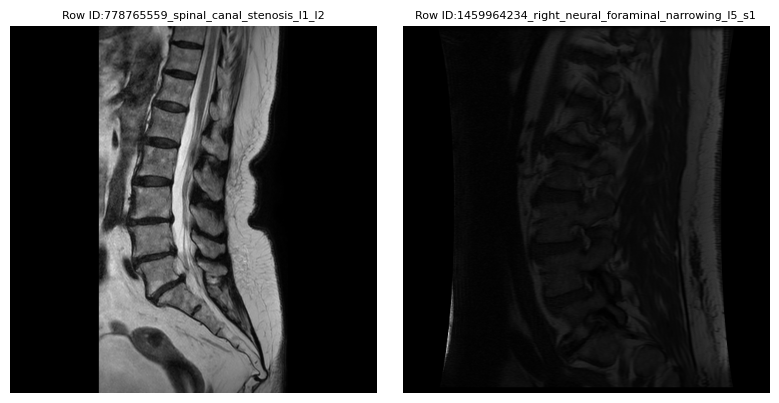

In [249]:
# Load images randomly 
import random 
images = []
row_ids = []
selected_indices = random.sample(range(len(train_data)),2)
for i in selected_indices:
    image = load_dicom(train_data['image_path'][i])
    images.append(image)
    row_ids.append(train_data['row_id'][i])
    
# Plot images
fig, ax = plt.subplots(1, 2, figsize = (8,4))
for i in range(2):    
    ax[i].imshow(images[i],cmap='gray') #plt.cm.bone
    ax[i].set_title(f'Row ID:{row_ids[i]}', fontsize = 8)
    ax[i].axis('off')
plt.tight_layout()
plt.show()    

In [250]:
nulls = train_data.isnull().sum()
print(f'The NULL or BLANK values in the final dataset by column-wise \n{nulls}')

The NULL or BLANK values in the final dataset by column-wise 
study_id               0
condition              0
level                  0
severity              35
series_id              0
instance_number        0
x                      0
y                      0
series_description     0
row_id                 0
image_path             0
study_id_exists        0
series_id_exists       0
image_exists           0
dtype: int64


In [251]:
# Removed the null values
train_data_set = train_data.dropna()
print(type(train_data_set), len(train_data_set))
train_data_set.head()

<class 'pandas.core.frame.DataFrame'> 48657


,study_id,condition,level,severity,series_id,instance_number,x,y,series_description,row_id,image_path,study_id_exists,series_id_exists,image_exists
0,4003253,Spinal Canal Stenosis,L1/L2,normal_mild,702807833,8,322.831858,227.964602,Sagittal T2/STIR,4003253_spinal_canal_stenosis_l1_l2,/kaggle/input/rsna-2024-lumbar-spine-degenerat...,True,True,True
1,4003253,Spinal Canal Stenosis,L2/L3,normal_mild,702807833,8,320.571429,295.714286,Sagittal T2/STIR,4003253_spinal_canal_stenosis_l2_l3,/kaggle/input/rsna-2024-lumbar-spine-degenerat...,True,True,True
2,4003253,Spinal Canal Stenosis,L3/L4,normal_mild,702807833,8,323.030303,371.818182,Sagittal T2/STIR,4003253_spinal_canal_stenosis_l3_l4,/kaggle/input/rsna-2024-lumbar-spine-degenerat...,True,True,True
3,4003253,Spinal Canal Stenosis,L4/L5,normal_mild,702807833,8,335.292035,427.327434,Sagittal T2/STIR,4003253_spinal_canal_stenosis_l4_l5,/kaggle/input/rsna-2024-lumbar-spine-degenerat...,True,True,True
4,4003253,Spinal Canal Stenosis,L5/S1,normal_mild,702807833,8,353.415929,483.964602,Sagittal T2/STIR,4003253_spinal_canal_stenosis_l5_s1,/kaggle/input/rsna-2024-lumbar-spine-degenerat...,True,True,True


In [252]:
exist_img = train_data_set['condition'].unique()
exist_img

array(['Spinal Canal Stenosis', 'Left Neural Foraminal Narrowing',
       'Right Neural Foraminal Narrowing', 'Left Subarticular Stenosis',
       'Right Subarticular Stenosis'], dtype=object)

In [253]:
# Filter out the DataFrame by series description
sagittal_t2_stir_data = train_data_set[train_data_set['series_description'] == 'Sagittal T2/STIR']
sagittal_t1_data = train_data_set[train_data_set['series_description'] == 'Sagittal T1']
axial_t2_data = train_data_set[train_data_set['series_description'] == 'Axial T2']

In [254]:
print("The length of the sagittal T2 / STIR data is", len(sagittal_t2_stir_data))
print("Severity count of unique values", sagittal_t2_stir_data['severity'].value_counts())
sagittal_t2_stir_data

The length of the sagittal T2 / STIR data is 9748
Severity count of unique values severity
normal_mild    8549
moderate        731
severe          468
Name: count, dtype: int64


,study_id,condition,level,severity,series_id,instance_number,x,y,series_description,row_id,image_path,study_id_exists,series_id_exists,image_exists
0,4003253,Spinal Canal Stenosis,L1/L2,normal_mild,702807833,8,322.831858,227.964602,Sagittal T2/STIR,4003253_spinal_canal_stenosis_l1_l2,/kaggle/input/rsna-2024-lumbar-spine-degenerat...,True,True,True
1,4003253,Spinal Canal Stenosis,L2/L3,normal_mild,702807833,8,320.571429,295.714286,Sagittal T2/STIR,4003253_spinal_canal_stenosis_l2_l3,/kaggle/input/rsna-2024-lumbar-spine-degenerat...,True,True,True
2,4003253,Spinal Canal Stenosis,L3/L4,normal_mild,702807833,8,323.030303,371.818182,Sagittal T2/STIR,4003253_spinal_canal_stenosis_l3_l4,/kaggle/input/rsna-2024-lumbar-spine-degenerat...,True,True,True
3,4003253,Spinal Canal Stenosis,L4/L5,normal_mild,702807833,8,335.292035,427.327434,Sagittal T2/STIR,4003253_spinal_canal_stenosis_l4_l5,/kaggle/input/rsna-2024-lumbar-spine-degenerat...,True,True,True
4,4003253,Spinal Canal Stenosis,L5/S1,normal_mild,702807833,8,353.415929,483.964602,Sagittal T2/STIR,4003253_spinal_canal_stenosis_l5_s1,/kaggle/input/rsna-2024-lumbar-spine-degenerat...,True,True,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48667,4290709089,Spinal Canal Stenosis,L1/L2,normal_mild,3274612423,9,181.668947,88.864569,Sagittal T2/STIR,4290709089_spinal_canal_stenosis_l1_l2,/kaggle/input/rsna-2024-lumbar-spine-degenerat...,True,True,True
48668,4290709089,Spinal Canal Stenosis,L2/L3,normal_mild,3274612423,9,174.227086,125.198358,Sagittal T2/STIR,4290709089_spinal_canal_stenosis_l2_l3,/kaggle/input/rsna-2024-lumbar-spine-degenerat...,True,True,True
48669,4290709089,Spinal Canal Stenosis,L3/L4,normal_mild,3274612423,9,174.227086,160.656635,Sagittal T2/STIR,4290709089_spinal_canal_stenosis_l3_l4,/kaggle/input/rsna-2024-lumbar-spine-degenerat...,True,True,True
48670,4290709089,Spinal Canal Stenosis,L4/L5,normal_mild,3274612423,9,182.544460,191.299590,Sagittal T2/STIR,4290709089_spinal_canal_stenosis_l4_l5,/kaggle/input/rsna-2024-lumbar-spine-degenerat...,True,True,True


In [255]:
print("The length of the sagittal T2 / STIR data is", len(sagittal_t1_data))
print("Severity count of unique values", sagittal_t1_data['severity'].value_counts())
sagittal_t1_data

The length of the sagittal T2 / STIR data is 19694
Severity count of unique values severity
normal_mild    15358
moderate        3560
severe           776
Name: count, dtype: int64


,study_id,condition,level,severity,series_id,instance_number,x,y,series_description,row_id,image_path,study_id_exists,series_id_exists,image_exists
5,4003253,Left Neural Foraminal Narrowing,L1/L2,normal_mild,1054713880,11,196.070671,126.021201,Sagittal T1,4003253_left_neural_foraminal_narrowing_l1_l2,/kaggle/input/rsna-2024-lumbar-spine-degenerat...,True,True,True
6,4003253,Left Neural Foraminal Narrowing,L2/L3,normal_mild,1054713880,12,191.321555,170.120141,Sagittal T1,4003253_left_neural_foraminal_narrowing_l2_l3,/kaggle/input/rsna-2024-lumbar-spine-degenerat...,True,True,True
7,4003253,Left Neural Foraminal Narrowing,L3/L4,normal_mild,1054713880,12,187.878354,217.245081,Sagittal T1,4003253_left_neural_foraminal_narrowing_l3_l4,/kaggle/input/rsna-2024-lumbar-spine-degenerat...,True,True,True
8,4003253,Left Neural Foraminal Narrowing,L4/L5,moderate,1054713880,11,186.504472,251.592129,Sagittal T1,4003253_left_neural_foraminal_narrowing_l4_l5,/kaggle/input/rsna-2024-lumbar-spine-degenerat...,True,True,True
9,4003253,Left Neural Foraminal Narrowing,L5/S1,normal_mild,1054713880,11,197.100569,289.457306,Sagittal T1,4003253_left_neural_foraminal_narrowing_l5_s1,/kaggle/input/rsna-2024-lumbar-spine-degenerat...,True,True,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48677,4290709089,Right Neural Foraminal Narrowing,L1/L2,normal_mild,4237840455,5,219.405706,95.459321,Sagittal T1,4290709089_right_neural_foraminal_narrowing_l1_l2,/kaggle/input/rsna-2024-lumbar-spine-degenerat...,True,True,True
48678,4290709089,Right Neural Foraminal Narrowing,L2/L3,normal_mild,4237840455,4,208.106799,140.203404,Sagittal T1,4290709089_right_neural_foraminal_narrowing_l2_l3,/kaggle/input/rsna-2024-lumbar-spine-degenerat...,True,True,True
48679,4290709089,Right Neural Foraminal Narrowing,L3/L4,normal_mild,4237840455,4,204.195639,182.791594,Sagittal T1,4290709089_right_neural_foraminal_narrowing_l3_l4,/kaggle/input/rsna-2024-lumbar-spine-degenerat...,True,True,True
48680,4290709089,Right Neural Foraminal Narrowing,L4/L5,normal_mild,4237840455,4,208.381925,222.922987,Sagittal T1,4290709089_right_neural_foraminal_narrowing_l4_l5,/kaggle/input/rsna-2024-lumbar-spine-degenerat...,True,True,True


In [256]:
print("The length of the sagittal T2 / STIR data is", len(axial_t2_data))
print("Severity count of unique values\n",axial_t2_data['severity'].value_counts())
axial_t2_data

The length of the sagittal T2 / STIR data is 19215
Severity count of unique values
 severity
normal_mild    13719
moderate        3659
severe          1837
Name: count, dtype: int64


,study_id,condition,level,severity,series_id,instance_number,x,y,series_description,row_id,image_path,study_id_exists,series_id_exists,image_exists
15,4003253,Left Subarticular Stenosis,L1/L2,normal_mild,2448190387,3,179.126448,161.235521,Axial T2,4003253_left_subarticular_stenosis_l1_l2,/kaggle/input/rsna-2024-lumbar-spine-degenerat...,True,True,True
16,4003253,Left Subarticular Stenosis,L2/L3,normal_mild,2448190387,11,180.979730,158.764479,Axial T2,4003253_left_subarticular_stenosis_l2_l3,/kaggle/input/rsna-2024-lumbar-spine-degenerat...,True,True,True
17,4003253,Left Subarticular Stenosis,L3/L4,normal_mild,2448190387,19,176.037645,157.528958,Axial T2,4003253_left_subarticular_stenosis_l3_l4,/kaggle/input/rsna-2024-lumbar-spine-degenerat...,True,True,True
18,4003253,Left Subarticular Stenosis,L4/L5,moderate,2448190387,28,172.948842,156.911197,Axial T2,4003253_left_subarticular_stenosis_l4_l5,/kaggle/input/rsna-2024-lumbar-spine-degenerat...,True,True,True
19,4003253,Left Subarticular Stenosis,L5/S1,normal_mild,2448190387,35,179.744208,161.853282,Axial T2,4003253_left_subarticular_stenosis_l5_s1,/kaggle/input/rsna-2024-lumbar-spine-degenerat...,True,True,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48687,4290709089,Right Subarticular Stenosis,L1/L2,normal_mild,3390218084,2,307.180844,354.869960,Axial T2,4290709089_right_subarticular_stenosis_l1_l2,/kaggle/input/rsna-2024-lumbar-spine-degenerat...,True,True,True
48688,4290709089,Right Subarticular Stenosis,L2/L3,normal_mild,3390218084,6,301.440933,362.044847,Axial T2,4290709089_right_subarticular_stenosis_l2_l3,/kaggle/input/rsna-2024-lumbar-spine-degenerat...,True,True,True
48689,4290709089,Right Subarticular Stenosis,L3/L4,normal_mild,3390218084,10,302.875911,356.304937,Axial T2,4290709089_right_subarticular_stenosis_l3_l4,/kaggle/input/rsna-2024-lumbar-spine-degenerat...,True,True,True
48690,4290709089,Right Subarticular Stenosis,L4/L5,normal_mild,3390218084,15,305.745866,340.520184,Axial T2,4290709089_right_subarticular_stenosis_l4_l5,/kaggle/input/rsna-2024-lumbar-spine-degenerat...,True,True,True


In [257]:
from sklearn.model_selection import StratifiedShuffleSplit

# Function to split the dataset proportionally for each type of severity
def split_dataset(df):

    # Define the stratified shuffle split
    strat_split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

    # Split the dataset
    for train_idx, val_idx in strat_split.split(df, df['severity']):
        df_train = df.iloc[train_idx].reset_index(drop=True)
        df_val = df.iloc[val_idx].reset_index(drop=True)
        
    return df_train, df_val

In [258]:
def split_check(df, df_train, df_val):
    # Calculate percentage distribution
    original_percent = (df['severity'].value_counts() / len(df)) * 100
    train_percent = (df_train['severity'].value_counts() / len(df_train)) * 100
    val_percent = (df_val['severity'].value_counts() / len(df_val)) * 100

    # Print percentage distribution for comparison
    print("Original Dataset Percentage Distribution:\n", original_percent)
    print("Training Set Percentage Distribution:\n", train_percent)
    print("Validation Set Percentage Distribution:\n", val_percent)

In [259]:
'''
sagittal_t2_stir_data
sagittal_t1_data
axial_t2_data
'''
# Splitting the datasets for training and validation
sag_t2STIR_train, sag_t2STIR_val = split_dataset(sagittal_t2_stir_data)
sag_t1_train, sag_t1_val = split_dataset(sagittal_t1_data)
axi_t2_train, axi_t2_val = split_dataset(axial_t2_data)

In [260]:
# Checking the percentage of training and validation splits
print(split_check(sagittal_t2_stir_data, sag_t2STIR_train, sag_t2STIR_val),'sagittal_t2_stir_data SPLIT\n')
print('sagittal_t1_data SPLIT\n', split_check(sagittal_t1_data, sag_t1_train, sag_t1_val))
print('axial_t2_data SPLIT\n', split_check(axial_t2_data, axi_t2_train, axi_t2_val))

Original Dataset Percentage Distribution:
 severity
normal_mild    87.700041
moderate        7.498974
severe          4.800985
Name: count, dtype: float64
Training Set Percentage Distribution:
 severity
normal_mild    87.701975
moderate        7.501924
severe          4.796102
Name: count, dtype: float64
Validation Set Percentage Distribution:
 severity
normal_mild    87.692308
moderate        7.487179
severe          4.820513
Name: count, dtype: float64
None sagittal_t2_stir_data SPLIT

Original Dataset Percentage Distribution:
 severity
normal_mild    77.983142
moderate       18.076572
severe          3.940286
Name: count, dtype: float64
Training Set Percentage Distribution:
 severity
normal_mild    77.981593
moderate       18.076801
severe          3.941606
Name: count, dtype: float64
Validation Set Percentage Distribution:
 severity
normal_mild    77.989337
moderate       18.075654
severe          3.935009
Name: count, dtype: float64
sagittal_t1_data SPLIT
 None
Original Dataset Pe

In [261]:
'''
def show_array(array,title=None):
    plt.imshow(array,cmap = 'gray')
    plt.title(title)
    plt.show()
'''    
def show_array(array, title=None, coordinates=None):
    plt.imshow(array, cmap='gray')
    if title:
        plt.title(title)
    if coordinates:
        x,y = coordinates
        plt.plot(x, y, 'ro')  # 'ro' means red color, circle marker
    plt.show()

In [262]:
im_coor_x = axi_t2_train['x'][1337]
im_coor_y = axi_t2_train['y'][1337]
coord = [(im_coor_x,im_coor_y)]
print(im_coor_x)
print(im_coor_y)
coord

318.2488226059655
454.75666270113817


[(318.2488226059655, 454.75666270113817)]

(320, 320)


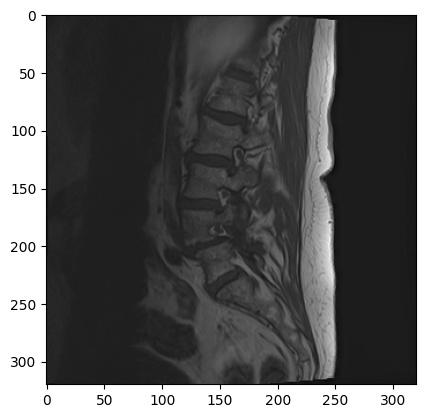

In [263]:
imt1 = load_dicom(sag_t1_train['image_path'][7359])  # sag_t2STIR_train, sag_t1_train, axi_t2_train
print(imt1.shape)
show_array(imt1)

In [264]:
im_path = axi_t2_train['image_path'][1337]
im_array = load_dicom(im_path)/255.0
im_title = axi_t2_train['severity'][1337]
#plt_array = show_array(im_array,im_title,coord)

In [265]:
im_df = pd.DataFrame(im_array.squeeze())
#im_df.style.background_gradient('Greys')